In [1]:
from IPython.display import display, Math
import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

### Define function

In [2]:
def show_matrix(A):
    plt.imshow(np.abs(A))
    plt.colorbar()
    plt.title(r"$|\mathcal{T}_{\text{choi}}|$")
    plt.show()

In [3]:
def complex_ndarray_to_latex_polar(A, precision=3, tol=1e-12):
    rows = []
    for row in A:
        entries = []
        for z in row:
            r = np.abs(z)
            theta = np.angle(z)

            if r < tol:
                entries.append("0")
            elif abs(theta) < tol:
                entries.append(f"{r:.{precision}f}")
            else:
                entries.append(
                    f"{r:.{precision}f} e^{{{theta:.{precision}f}\\,\\mathrm{{i}}}}"
                )
        rows.append(" & ".join(entries))

    body = r" \\ ".join(rows)
    return r"\begin{pmatrix}" + body + r"\end{pmatrix}"

In [4]:
def apply_channel_from_choi(A, x):
    d_in = x.shape[0]
    d_out = A.shape[0] // d_in

    IxT = np.kron(np.eye(d_out), x.T)
    M = IxT @ A

    M = M.reshape(d_out, d_in, d_out, d_in)

    y = np.einsum('a i b i -> a b', M)

    return y

In [5]:
def copy_maker(x, n_copies):
    result = x
    for _ in range(n_copies - 1):
        result = np.kron(result, x)
    return result


def fidelity(x, y):
    sqrt_x = sqrtm(x)
    m = sqrt_x @ y @ sqrt_x

    sqrt_m = sqrtm(m)
    F = np.real(np.trace(sqrt_m))**2

    return F

In [6]:
def pure_state_maker(d, k):
    x = np.zeros((d, d), dtype=complex)
    x[k, k] = 1.0
    return x

def maximally_mixed_state_maker(d):
    x = np.eye(d, dtype=complex)
    x /= d
    return x

def random_mixed_state_maker(d):
    A = np.random.randn(d, d) + 1j * np.random.randn(d, d)
    rho = A @ A.conj().T
    rho /= np.trace(rho)
    
    return rho

In [7]:
import os 
import ast

def load_choi_blocks(filename: str) -> dict:
    if not os.path.exists(filename):
        raise FileNotFoundError(f"파일 없음: {filename}")

    blocks = {}
    with np.load(filename, allow_pickle=True) as data:
        for k in data.files:
            try:
                # ast.literal_eval을 사용하여 "(5, 2)" -> (5, 2) 복원
                key_tuple = ast.literal_eval(k)
                blocks[key_tuple] = data[k].copy()
            except (ValueError, SyntaxError):
                # 변환 불가능한 키는 스킵
                continue
    return blocks

In [8]:
from utils import *

def rho_blocks(n: int, p: float, j2_list):
        return {j2: rho_block_diag_in_spin_irrep(n, j2, p) for j2 in j2_list}
    
def apply_channel_blocks_numpy(J_blocks, p: float, n_in: int, n_out: int):
    j2_in_list = j2_list_for_n_qubits(n_in)
    j2_out_list = j2_list_for_n_qubits(n_out)
    rho_in = rho_blocks(n_in, float(p), j2_in_list)
    mult_in = {j2: mult_qubits(n_in, j2) for j2 in j2_in_list}
    sigma = {}
    for j2o in j2_out_list:
        d_out = j2o + 1
        sig = np.zeros((d_out, d_out), dtype=complex)
        for j2i in j2_in_list:
            d_in = j2i + 1
            J = J_blocks[(j2o, j2i)]
            K = np.kron(np.eye(d_out, dtype=complex), rho_in[j2i].T)
            M = K @ J
            sig_part = partial_trace_numpy(M, d_out, d_in, axis=1)
            sig += mult_in[j2i] * sig_part
        sigma[j2o] = (sig + sig.conj().T) / 2
    return sigma

def fidelity_block(p: float, sigma_blocks, n_out):
    j2_out_list = j2_list_for_n_qubits(n_out)
    alpha = rho_blocks(n_out, float(p), j2_out_list)
    f = 0.0
    for j2o in j2_out_list:
        f_j = fidelity_root_numpy(alpha[j2o], sigma_blocks[j2o])
        f += mult_qubits(n_out, j2o) * f_j
    return float(f) ** 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def visualize_schur_channel(data_dict):
    """Schur basis에서 블록별로 정의된 채널 데이터를 시각화합니다.
        data_dict: {(j2o, j2i): array, ...}
    """
    all_j2o = sorted(list(set(k[0] for k in data_dict.keys())), reverse=True)
    all_j2i = sorted(list(set(k[1] for k in data_dict.keys())), reverse=True)
    
    row_offsets = {}
    curr_row = 0
    for j2 in all_j2o:
        sample_key = next(k for k in data_dict.keys() if k[0] == j2)
        row_offsets[j2] = curr_row
        curr_row += data_dict[sample_key].shape[0]
        
    col_offsets = {}
    curr_col = 0
    for j2 in all_j2i:
        sample_key = next(k for k in data_dict.keys() if k[1] == j2)
        col_offsets[j2] = curr_col
        curr_col += data_dict[sample_key].shape[1]

    full_matrix = np.zeros((curr_row, curr_col), dtype=complex)

    for (j2o, j2i), block in data_dict.items():
        r_start = row_offsets[j2o]
        r_end = r_start + block.shape[0]
        c_start = col_offsets[j2i]
        c_end = c_start + block.shape[1]
        full_matrix[r_start:r_end, c_start:c_end] = block
        
    plt.figure(figsize=(10, 8))
    vis_matrix = np.abs(full_matrix) + 1e-45
    
    im = plt.imshow(vis_matrix, norm=LogNorm(vmin=1e-10, vmax=vis_matrix.max()), 
                    cmap='viridis', interpolation='nearest')
    
    # 구분선
    for r in row_offsets.values():
        plt.axhline(r - 0.5, color='white', linewidth=0.5, alpha=0.5)
    for c in col_offsets.values():
        plt.axvline(c - 0.5, color='white', linewidth=0.5, alpha=0.5)

    plt.colorbar(im, label='Absolute Value (Log Scale)')
    plt.title("Quantum Channel in Schur Basis (Block-Diagonal Structure)")
    plt.xlabel("Input Multiplicity Index (j2i)")
    plt.ylabel("Output Multiplicity Index (j2o)")
    
    plt.xticks(list(col_offsets.values()), all_j2i)
    plt.yticks(list(row_offsets.values()), all_j2o)
    
    plt.tight_layout()
    plt.show()

In [79]:
import numpy as np
import pandas as pd
from scipy.special import comb

def get_young_label(n, j2):
    """n과 j2(2j)를 받아 Young diagram 형상 (n1, n2)을 반환"""
    # j = j2 / 2
    # n1 + n2 = n, n1 - n2 = 2j = j2
    n1 = (n + j2) // 2
    n2 = (n - j2) // 2
    return (n1, n2) if n2 > 0 else (n1,)

def mult_qubits(n, j2):
    if (n - j2) % 2 != 0 or j2 > n:
        return 0
    k = (n - j2) // 2
    return int(comb(n, k) - comb(n, k - 1)) if k > 0 else 1

def calculate_transformation_rates_young(data_dict, n_in=2, n_out=10):
    j2i_list = sorted(list(set(k[1] for k in data_dict.keys())), reverse=True)
    j2o_list = sorted(list(set(k[0] for k in data_dict.keys())), reverse=True)
    
    rate_matrix = np.zeros((len(j2i_list), len(j2o_list)))
    
    for r, j2i in enumerate(j2i_list):
        dim_su2_in = j2i + 1 # 2j + 1
        for c, j2o in enumerate(j2o_list):
            if (j2o, j2i) in data_dict:
                B = data_dict[(j2o, j2i)]
                m_out = mult_qubits(n_out, j2o)
                # P(jo|ji) = m_out * Tr(B) / (2ji + 1)
                prob = (m_out * np.trace(B).real) / dim_su2_in
                rate_matrix[r, c] = prob
                
    # Young diagram 라벨 생성
    row_labels = [str(get_young_label(n_in, j)) for j in j2i_list]
    col_labels = [str(get_young_label(n_out, j)) for j in j2o_list]
    
    df = pd.DataFrame(rate_matrix, index=row_labels, columns=col_labels)
    return df


### Load choi operator

In [110]:
d = 2

### change this parameter!!!
method = "sdp_perm"  # "sdp_fix", "sdp", "sdp_perm_fix", "sdp_perm"
n_in = 2
n_out = 5
###########################

if method in ["sdp", "sdp_fix"]:
    A = np.load(f"data/{method}/{n_in}_to_{n_out}.npy")
else:
    A = load_choi_blocks(f"data/{method}/{n_in}_to_{n_out}.npz")

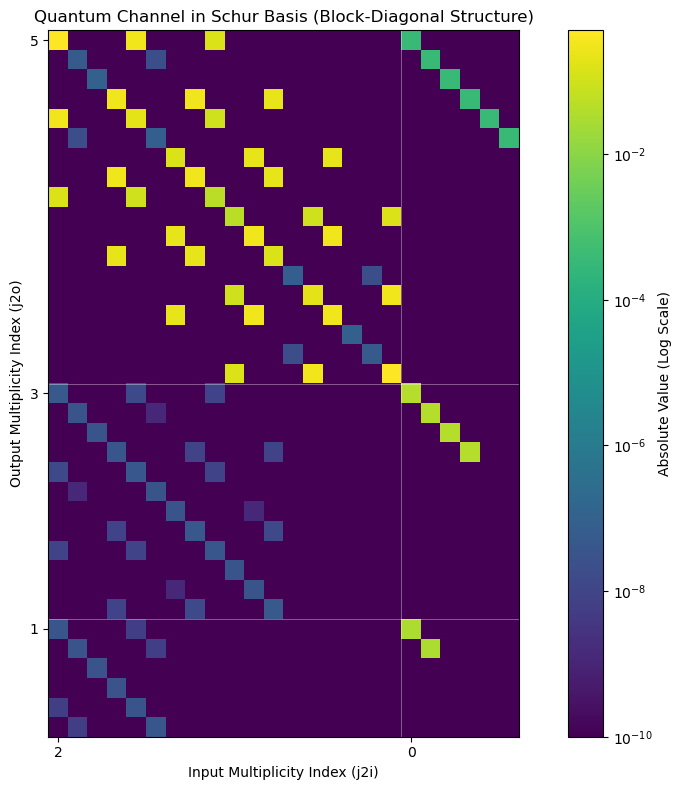

In [111]:
# print(A)
if method in ["sdp", "sdp_fix"]:
    show_matrix(A)
else:
    visualize_schur_channel(A)

In [109]:
if method not in ["sdp", "sdp_fix"]:    
    df = calculate_transformation_rates_young(A, n_in=n_in, n_out=n_out)
    df_clean = df.map(lambda x: x if x > 1e-6 else 0)
    df_clean['sum'] = df_clean.sum(axis=1)

    print(df_clean.to_string(float_format="{:.4f}".format))

        (23,)  (22, 1)  (21, 2)  (20, 3)  (19, 4)  (18, 5)  (17, 6)  (16, 7)  (15, 8)  (14, 9)  (13, 10)  (12, 11)    sum
(3,)   0.8343   0.0256   0.0332   0.0239   0.0150   0.0112   0.0107   0.0114   0.0126   0.0116    0.0080    0.0026 1.0000
(2, 1) 0.0002   0.1141   0.1522   0.1968   0.1810   0.1313   0.0881   0.0598   0.0382   0.0237    0.0107    0.0037 1.0000


In [103]:
if method in ["sdp", "sdp_fix"]:
    x_min = pure_state_maker(d) 
    y_min = apply_channel_from_choi(A, copy_maker(x_min, n_in))

    latex_str = complex_ndarray_to_latex_polar(y_min)
    display(Math(r"y = " + latex_str))
    f_pure = fidelity(copy_maker(x_min, n_out), y_min)
    
    x_max = maximally_mixed_state_maker(d) 
    y_max = apply_channel_from_choi(A, copy_maker(x_max, n_in))

    latex_str = complex_ndarray_to_latex_polar(y_max)
    display(Math(r"y = " + latex_str))
    f_mixed = fidelity(copy_maker(x_max, n_out), y_max)
else:
    sigma_blocks = apply_channel_blocks_numpy(A, float(1.0), n_in=n_in, n_out=n_out)
    f_pure = fidelity_block(float(1.0), sigma_blocks, n_out=n_out)
    sigma_blocks = apply_channel_blocks_numpy(A, float(0.5), n_in=n_in, n_out=n_out)
    f_mixed = fidelity_block(float(0.5), sigma_blocks, n_out=n_out)
        

print("Pure state fidelity: ", f_pure)
print("Maximally mixed state fidelity: ", f_mixed)

Pure state fidelity:  0.15268401348357644
Maximally mixed state fidelity:  0.18311793045468838


In [104]:
if method in ["sdp", "sdp_fix"]:
    x_rand = random_mixed_state_maker(d) 
    y_rand = apply_channel_from_choi(A, copy_maker(x_rand, n_in))

    latex_str_x = complex_ndarray_to_latex_polar(copy_maker(x_rand, n_out))
    latex_str_y = complex_ndarray_to_latex_polar(y_rand)
    f_rnd = fidelity(copy_maker(x_rand, n_out), y_rand)
else:
    p = np.random.uniform(0.5, 1.0)
    sigma_blocks = apply_channel_blocks_numpy(A, float(p), n_in=n_in, n_out=n_out)
    f_rnd = fidelity_block(float(p), sigma_blocks, n_out=n_out)
print("Random mixed state fidelity: ", f_rnd)

Random mixed state fidelity:  0.17062328099564214


[1/50] p = 0.500, Fidelity = 0.183118
[2/50] p = 0.510, Fidelity = 0.183156
[3/50] p = 0.520, Fidelity = 0.183267
[4/50] p = 0.531, Fidelity = 0.183449
[5/50] p = 0.541, Fidelity = 0.183696
[6/50] p = 0.551, Fidelity = 0.183999
[7/50] p = 0.561, Fidelity = 0.184347
[8/50] p = 0.571, Fidelity = 0.184727
[9/50] p = 0.582, Fidelity = 0.185126
[10/50] p = 0.592, Fidelity = 0.185527
[11/50] p = 0.602, Fidelity = 0.185912
[12/50] p = 0.612, Fidelity = 0.186261
[13/50] p = 0.622, Fidelity = 0.186556
[14/50] p = 0.633, Fidelity = 0.186775
[15/50] p = 0.643, Fidelity = 0.186897
[16/50] p = 0.653, Fidelity = 0.186903
[17/50] p = 0.663, Fidelity = 0.186772
[18/50] p = 0.673, Fidelity = 0.186487
[19/50] p = 0.684, Fidelity = 0.186031
[20/50] p = 0.694, Fidelity = 0.185389
[21/50] p = 0.704, Fidelity = 0.184550
[22/50] p = 0.714, Fidelity = 0.183508
[23/50] p = 0.724, Fidelity = 0.182256
[24/50] p = 0.735, Fidelity = 0.180798
[25/50] p = 0.745, Fidelity = 0.179139
[26/50] p = 0.755, Fidelity = 0.17

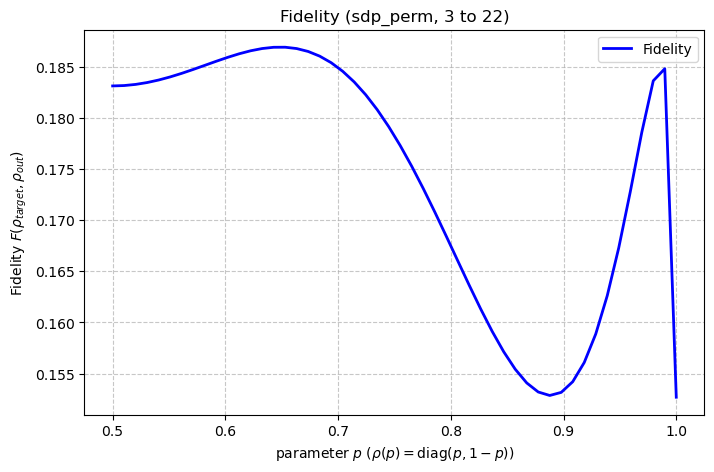

In [105]:
import numpy as np
import matplotlib.pyplot as plt


def generate_diagonal_rho(p, d):
    """
    p: 첫 번째 대각 성분의 확률 값 (0.5 <= p <= 1.0)
    d: Hilbert 공간의 차원
    """
    rho = np.zeros((d, d), dtype=complex)
    rho[0, 0] = p
    if d > 1:
        # 나머지 성분들에 대해 (1-p)를 균등 배분 (Tr(rho) = 1 유지)
        remaining_val = (1 - p) / (d - 1)
        for i in range(1, d):
            rho[i, i] = remaining_val
    return rho

# 실험 설정
n_grid = 50
p_values = np.linspace(0.5, 1.0, n_grid)
fidelities = []

# 기존에 정의된 d, A, n_in, n_out 변수가 존재한다고 가정함
for i, p in enumerate(p_values):
    if method in ["sdp", "sdp_fix"]:
        # 1. 대각 입력 상태 rho 생성
        rho_p = generate_diagonal_rho(p, d)
        
        # 2. 채널 적용: y = Phi(rho^{\otimes n_in})
        # 사용자의 코드 구조에 따라 copy_maker를 적용
        x_input = copy_maker(rho_p, n_in)
        y_out = apply_channel_from_choi(A, x_input)
        
        # 3. 기준 상태(Target) 생성 및 Fidelity 계산
        # 사용자의 snippet 기준: copy_maker(rho_p, n_out)와 비교
        target_state = copy_maker(rho_p, n_out)
        f = fidelity(target_state, y_out)
    
    else:
        sigma_blocks = apply_channel_blocks_numpy(A, float(p), n_in=n_in, n_out=n_out)
        f = fidelity_block(float(p), sigma_blocks, n_out=n_out)
    
    fidelities.append(f)
    
    print(f"[{i+1}/{n_grid}] p = {p:.3f}, Fidelity = {f:.6f}")

# 그래프 출력
plt.figure(figsize=(8, 5))
plt.plot(p_values, fidelities, label='Fidelity', color='blue', linewidth=2)
plt.xlabel(r'parameter $p$ ($\rho(p) = \mathrm{diag}(p, 1-p)$)')
plt.ylabel(r'Fidelity $F(\rho_{target}, \rho_{out})$')
plt.title(f'Fidelity ({method}, {n_in} to {n_out})')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.savefig(f"figure/fidelity_{method}_{n_in}_to_{n_out}.png")
plt.show()

### [Go to setting block](#load-choi-operator)